**Main Assignment Conditions**

Interconnect, a telecom operator, aims to predict customer churn. In the event that a user intends to terminate their services, Interconnect plans to offer them promotional codes and special plan options. To achieve this, Interconnect's marketing team has gathered personal data of their clientele, including details about their plans and contracts.

**Interconnect's services**

Interconnect mainly provides two types of services:

1. **Landline communication**. The telephone can be connected to several lines simultaneously.
2. **Internet**. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

The company also offers several other services:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

Clients have the option to choose between a monthly payment or signing a 1- or 2-year contract. They can utilize various payment methods and receive an electronic invoice after completing a transaction.

**Data Description**

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

It is important to note that the contract information provided is valid as of February 1, 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import seaborn as sns

In [2]:
# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report,precision_recall_curve,average_precision_score, auc
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score,confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv as catboost_cv

In [3]:
# Install sorted containers Library
! pip install sortedcontainers

# Load Datasets

In [4]:
# Load datasets define index as customer ID
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [5]:
# rename columns as lowercase 
contract.columns = map(str.lower, contract.columns)
personal.columns = map(str.lower, personal.columns)
internet.columns = map(str.lower, internet.columns)
phone.columns = map(str.lower, phone.columns)

# Pre-processing and dataset preparation

**<h2>Dataset Contract**

In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   begindate         7043 non-null   object 
 1   enddate           7043 non-null   object 
 2   type              7043 non-null   object 
 3   paperlessbilling  7043 non-null   object 
 4   paymentmethod     7043 non-null   object 
 5   monthlycharges    7043 non-null   float64
 6   totalcharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [7]:
contract.head()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
contract['begindate'] = pd. to_datetime(contract['begindate'])

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   object        
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [10]:
contract.loc[contract['totalcharges'].str.contains(' ')]

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Total charges contain missing values.

In [11]:
contract.describe()

,monthlycharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [12]:
contract.index.duplicated().sum()

0

In [13]:
# check for imbalance data for modeling
not_ended = len(contract[contract['enddate'] == 'No'])
ended = len(contract) - not_ended

print('Total customer : ', len(contract))
print(f'Total ended customer     : {ended} ({round(ended/len(contract), 2)*100}%)')
print(f'Total continues customer : {not_ended} ({round(not_ended/len(contract), 2)*100}%)')

Total customer :  7043
Total ended customer     : 1869 (27.0%)
Total continues customer : 5174 (73.0%)


The ML Model's objective is to address the issue of class imbalance.

**<h2>Dataset Personal**

In [14]:
personal.head()

,gender,seniorcitizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   seniorcitizen  7043 non-null   int64 
 2   partner        7043 non-null   object
 3   dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [16]:
personal.index.duplicated().sum()

0

**<h2>Dataset Internat**

In [17]:
internet.head()

,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   internetservice   5517 non-null   object
 1   onlinesecurity    5517 non-null   object
 2   onlinebackup      5517 non-null   object
 3   deviceprotection  5517 non-null   object
 4   techsupport       5517 non-null   object
 5   streamingtv       5517 non-null   object
 6   streamingmovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [19]:
internet.index.duplicated().sum()

0

**<h2>Dataset Phone**

In [20]:
phone.head()

,multiplelines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [21]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   multiplelines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [22]:
phone.index.duplicated().sum()

0

Let us construct a single dataframe. I have verified that all datasets possess a one-to-one connection, at least within the current datasets.

In [23]:
#Merge dataframe as single dataset
data = (personal
   .merge(contract, how="left", on="customerID")
   .merge(phone, how="left", on="customerID")
   .merge(internet, how="left", on="customerID"))

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   seniorcitizen     7043 non-null   int64         
 2   partner           7043 non-null   object        
 3   dependents        7043 non-null   object        
 4   begindate         7043 non-null   datetime64[ns]
 5   enddate           7043 non-null   object        
 6   type              7043 non-null   object        
 7   paperlessbilling  7043 non-null   object        
 8   paymentmethod     7043 non-null   object        
 9   monthlycharges    7043 non-null   float64       
 10  totalcharges      7043 non-null   object        
 11  multiplelines     6361 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup  

In [25]:
data.head()

,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


In my perspective, there is a lack of information regarding internet services due to the fact that these clients solely rely on phone services and do not have access to internet service. To address this, we can input a "No" value to complete the missing data.

In [26]:
for col in ["onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv",	"streamingmovies"]:
  data[col] = data[col].fillna("No")

In [27]:
data["multiplelines"] = data["multiplelines"].fillna("No")
data["internetservice"] = data["internetservice"].fillna("No Service")

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   seniorcitizen     7043 non-null   int64         
 2   partner           7043 non-null   object        
 3   dependents        7043 non-null   object        
 4   begindate         7043 non-null   datetime64[ns]
 5   enddate           7043 non-null   object        
 6   type              7043 non-null   object        
 7   paperlessbilling  7043 non-null   object        
 8   paymentmethod     7043 non-null   object        
 9   monthlycharges    7043 non-null   float64       
 10  totalcharges      7043 non-null   object        
 11  multiplelines     7043 non-null   object        
 12  internetservice   7043 non-null   object        
 13  onlinesecurity    7043 non-null   object        
 14  onlinebackup  

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job on data preprocessing! Dataframes were merged correctly

</div>

# EDA

In [29]:
data["gender"] = (data["gender"] == "Male").astype("int")

In [30]:
for col in data.select_dtypes("object").columns:
  if sorted(data[col].unique())==["No","Yes"]:
    data[col] = (data[col] == "Yes").astype("int")

In [31]:
data[data["totalcharges"]==" "]

,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,0,0,1,1,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,,0,DSL,1,0,1,1,1,0
3115-CZMZD,1,0,0,1,2020-02-01,No,Two year,0,Mailed check,20.25,,0,No Service,0,0,0,0,0,0
5709-LVOEQ,0,0,1,1,2020-02-01,No,Two year,0,Mailed check,80.85,,0,DSL,1,1,1,0,1,1
4367-NUYAO,1,0,1,1,2020-02-01,No,Two year,0,Mailed check,25.75,,1,No Service,0,0,0,0,0,0
1371-DWPAZ,0,0,1,1,2020-02-01,No,Two year,0,Credit card (automatic),56.05,,0,DSL,1,1,1,1,1,0
7644-OMVMY,1,0,1,1,2020-02-01,No,Two year,0,Mailed check,19.85,,0,No Service,0,0,0,0,0,0
3213-VVOLG,1,0,1,1,2020-02-01,No,Two year,0,Mailed check,25.35,,1,No Service,0,0,0,0,0,0
2520-SGTTA,0,0,1,1,2020-02-01,No,Two year,0,Mailed check,20.00,,0,No Service,0,0,0,0,0,0
2923-ARZLG,1,0,1,1,2020-02-01,No,One year,1,Mailed check,19.70,,0,No Service,0,0,0,0,0,0


It appears that the data gathering date is prior to 2020-03-01, resulting in empty TotalCharges for clients whose BeginDate is after 2020-02-01.

In [32]:
data["totalcharges"] = pd.to_numeric(data["totalcharges"], errors="coerce").fillna(0.0)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   int64         
 1   seniorcitizen     7043 non-null   int64         
 2   partner           7043 non-null   int64         
 3   dependents        7043 non-null   int64         
 4   begindate         7043 non-null   datetime64[ns]
 5   enddate           7043 non-null   object        
 6   type              7043 non-null   object        
 7   paperlessbilling  7043 non-null   int64         
 8   paymentmethod     7043 non-null   object        
 9   monthlycharges    7043 non-null   float64       
 10  totalcharges      7043 non-null   float64       
 11  multiplelines     7043 non-null   int64         
 12  internetservice   7043 non-null   object        
 13  onlinesecurity    7043 non-null   int64         
 14  onlinebackup  

In [34]:
data["churn"] = (data["enddate"]!="No").astype("int")

In [35]:
data = data.drop(["begindate","enddate"], axis=1)

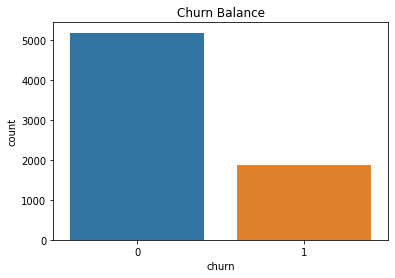

In [36]:
sns.countplot(data["churn"]).set(title='Churn Balance')
plt.show()

In [37]:
print('zeros ',data[data['churn']==0]['churn'].count(),
', Ones ',data[data['churn']==1]['churn'].count(),', ratio ',data[data['churn']==0]['churn'].count()/data[data['churn']==1]['churn'].count())

zeros  5174 , Ones  1869 , ratio  2.7683253076511503


the chart indicate the imbalanced data 

In [38]:
if "customerID" in data.columns:
  data = data.drop("customerID", axis=1)
categories = ["type", "paymentmethod", "internetservice", "gender", "seniorcitizen","partner","dependents", "paperlessbilling", "multiplelines", \
              "onlinesecurity",	"onlinebackup",	"deviceprotection",	"techsupport","streamingtv","streamingmovies" ]
target = "churn"
features = list(set(data.columns) - set([target]))

In [39]:
def plot_group_density(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=16)
    ax.set_xlabel(on, fontsize=16)
    return ax 

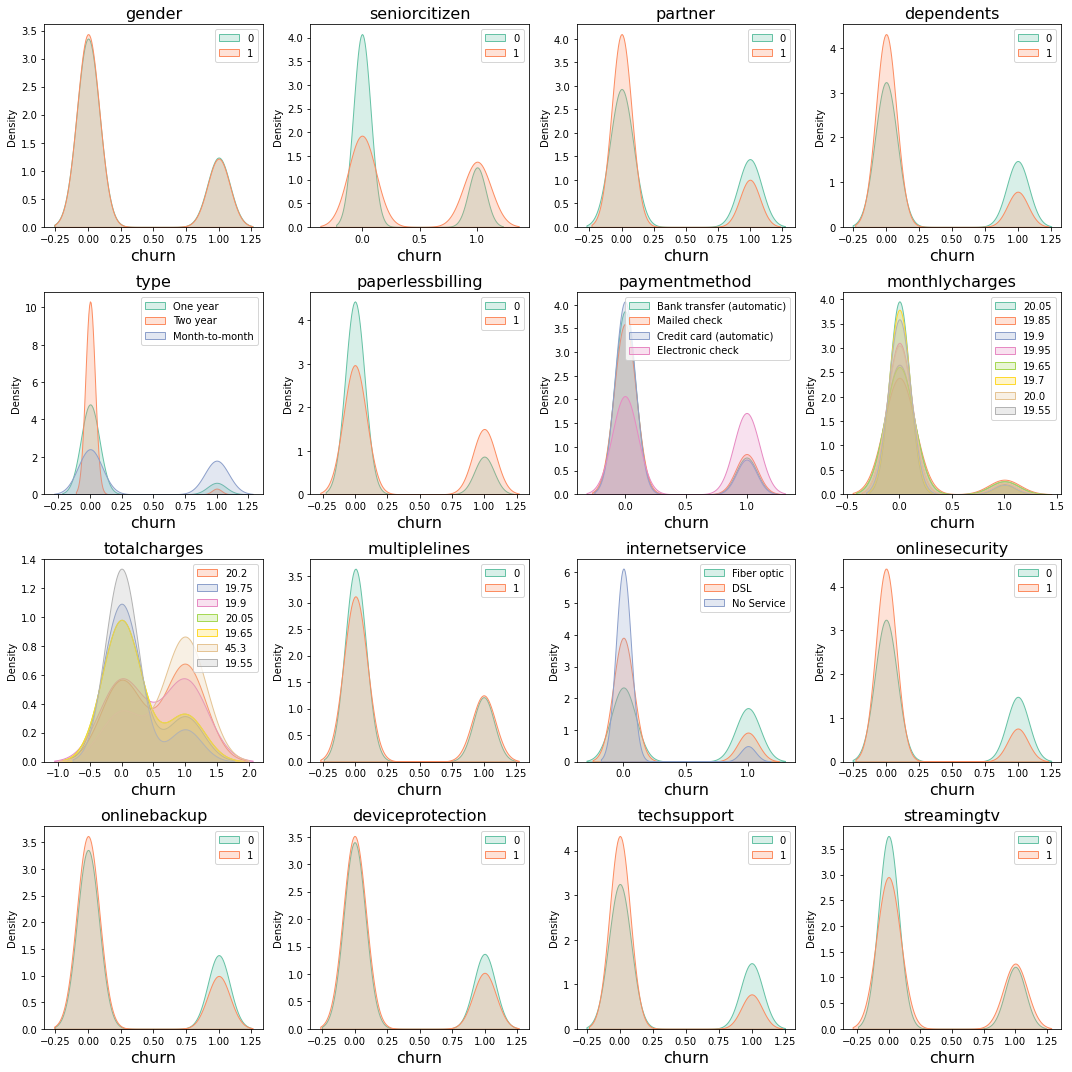

In [40]:
fig, axs = plt.subplots(4, len(data.columns) // 4, figsize=(15,15))
axs = axs.flatten()

for cat_col, ax in zip(data.columns, axs):
    plot_group_density(data, groupby = cat_col, on = target, \
                                    palette = sns.color_palette('Set2'),title=cat_col, \
                                    figsize = (10, 5), ax=ax)
    ax.legend()


plt.tight_layout()
plt.show()

Based on the data analysis, it is evident that Type and Total Charges exhibit intriguing patterns. By examining the density, we can infer that customers who recently joined on a month-to-month basis and have higher charges tend to have a higher likelihood of churn.

Let's examine the densities based on charges.

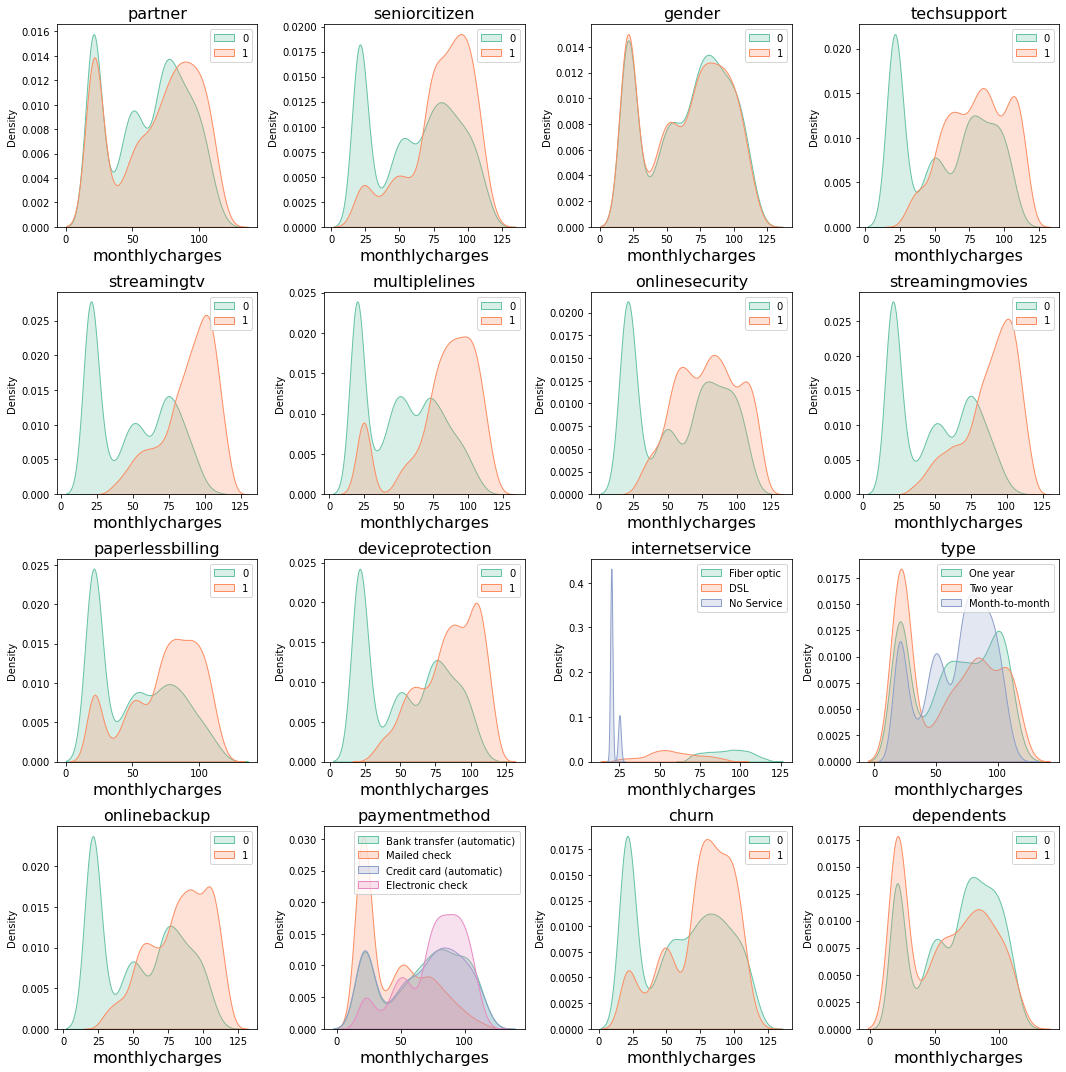

In [41]:
cols = list(set(data.columns) - set(["monthlycharges", "totalcharges"]))
fig, axs = plt.subplots(4, len(cols) // 4, figsize=(15,15))
axs = axs.flatten()

for cat_col, ax in zip(cols, axs):
    plot_group_density(data, groupby = cat_col, on = "monthlycharges", \
                                           palette = sns.color_palette('Set2'), 
                                title=cat_col,
                           figsize = (10, 5), ax=ax)
    ax.legend()


plt.tight_layout()
plt.show()

It appears that the charges vary depending on the type of payment, and it is evident that monthly clients incur higher fees.

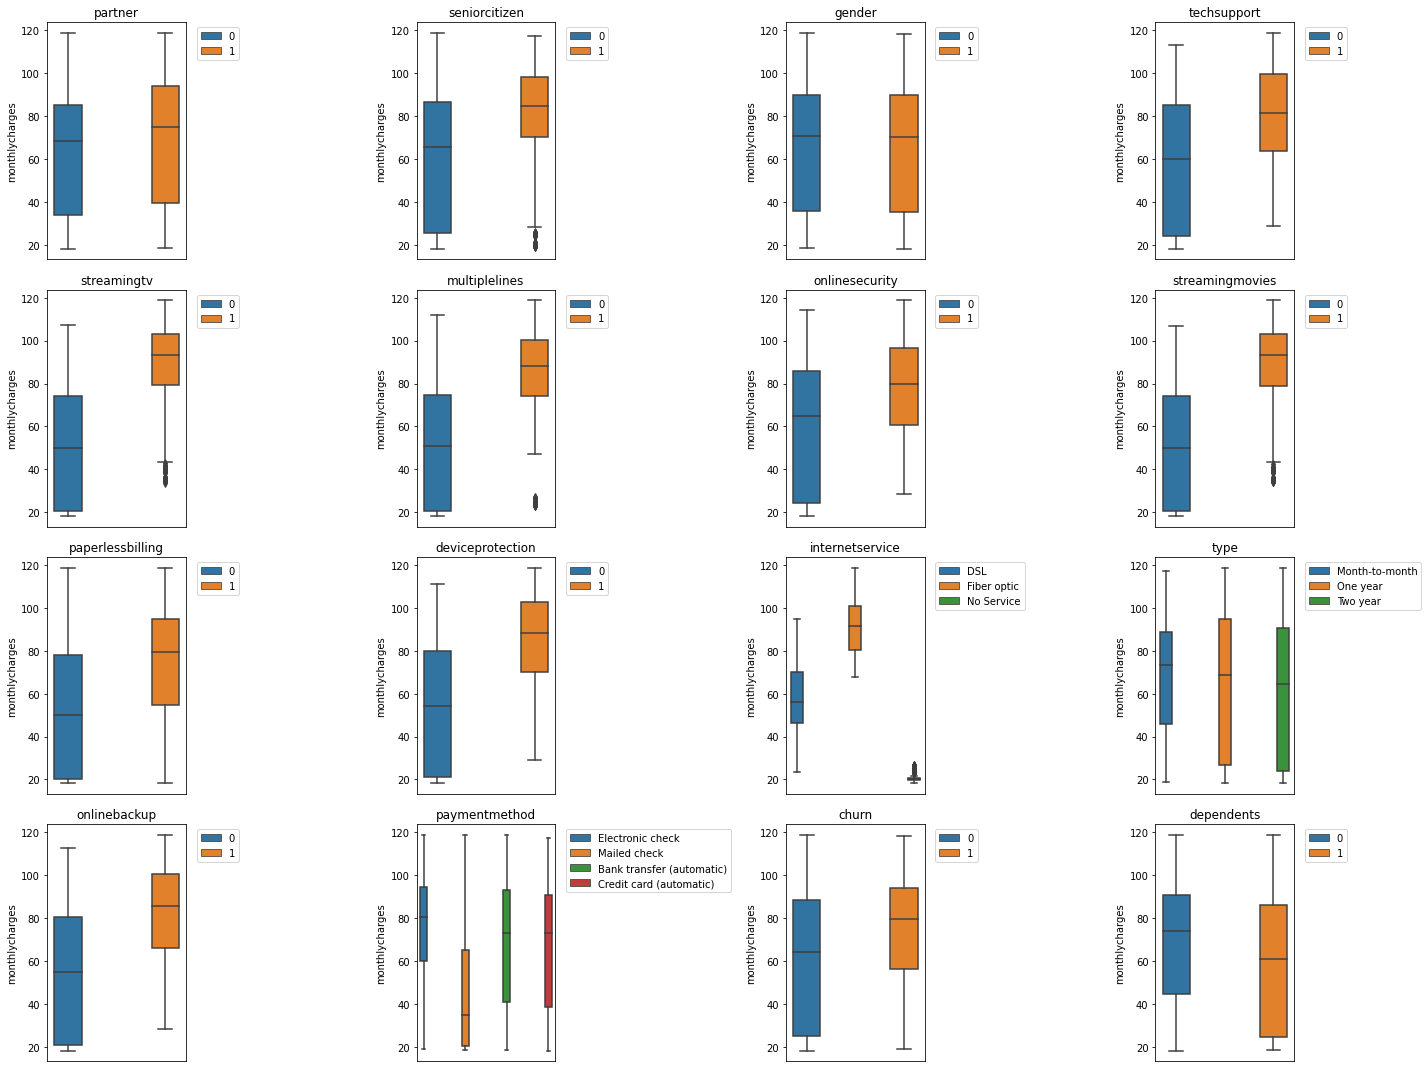

In [42]:
cols = list(set(data.columns) - set(["monthlycharges", "totalcharges"]))
fig, axs = plt.subplots(4, len(cols) // 4, figsize=(20,15))
axs = axs.flatten()

for cat_col, ax in zip(cols, axs):
    sns.boxplot(x=cat_col, y="monthlycharges", hue=cat_col, data=data, ax=ax)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_title(cat_col)


plt.tight_layout()
plt.show()

In [43]:
corr_df = data.corr()
corr_df.iloc[corr_df['churn'].abs().argsort()]["churn"]

gender             -0.008612
multiplelines       0.040102
streamingmovies     0.061382
streamingtv         0.063228
deviceprotection   -0.066160
onlinebackup       -0.082255
partner            -0.150448
seniorcitizen       0.150889
dependents         -0.164221
techsupport        -0.164674
onlinesecurity     -0.171226
paperlessbilling    0.191825
monthlycharges      0.193356
totalcharges       -0.198324
churn               1.000000
Name: churn, dtype: float64

Let's examine the key attributes based on the catboost classifier.

In [44]:
random_state = 42
X, y = data[features], data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
train_ds = Pool(data=X_train, label=y_train, cat_features=categories, feature_names=features)
test_ds = Pool(data=X_test, label=y_test, cat_features=categories, feature_names=features)
full_ds = Pool(data=X, label=y, cat_features=categories, feature_names=features)
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
#cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight, random_seed=random_state,task_type="GPU", devices='0:1').fit(train_ds)
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight, random_seed=random_state).fit(train_ds)
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )


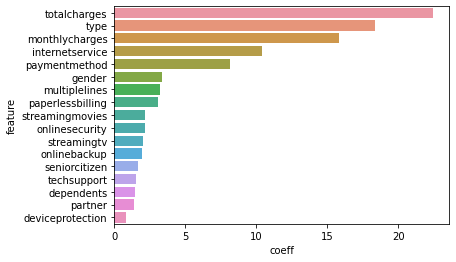

In [45]:
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])
sns.set(rc={"figure.figsize":(15, 8)})
plt.show()

Based on the plan summary, it can be inferred that customers who have high monthly charges (exceeding 70) but not high total charges (hence the different correlation signs) tend to cancel their service. These customers are more inclined towards internet services that offer electronic payment options.

Next, we will proceed to constructing models and identifying the most suitable one based on our metric.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice EDA!

</div>

# Models

Please submit the code for your solution.

The project reviewers will evaluate your submission based on the following criteria:
- Have you completed all the required steps?
- Does your solution meet the task conditions?
- Have you properly trained and tested the model?
- What is the quality score of the best model?
- Have you followed the project structure as instructed?
- Is your code well-organized and easy to read?

Please ensure that your code meets these criteria before uploading it.

In [46]:
# chart functions
def display_classification_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)

def plot_roc(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        if not ax: fig, ax = plt.subplots(1, 1)
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        ax.plot([0, 1], [0, 1],'r--')
        ax.plot(fpr, tpr, lw=2, label=label)
        ax.legend(loc='lower right')
        ax.set_title(
             'ROC curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(fpr, tpr):.2}')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.annotate(f'AUC: {auc(fpr, tpr):.2}', xy=(.43, .025))
        ax.legend()
        ax.grid()
        return ax
    

def plot_pr(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        if not ax: fig, ax = plt.subplots()
        ax.plot([0, 1], [1, 0],'r--')    
        ax.plot(recall, precision, lw=2, label=label)
        ax.legend()
        ax.set_title(
            'Precision-recall curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(recall, precision):.2}'
        )
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid()
        return ax

Based on our previous research, it has been observed that a number of recent clients tend to discontinue using our service for various reasons. In order to address this, we propose implementing a feature that tracks the duration of time clients utilize our service.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good idea!

</div>

In [65]:
data['churn'].head()

customerID
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    1
7795-CFOCW    0
9237-HQITU    1
Name: churn, dtype: int64

In [126]:
from functools import lru_cache
from sklearn.preprocessing import StandardScaler

@lru_cache(1)
def get_data(path=".", oversampling=True, apply_dummies=False):
    target = 'churn'

    df = (personal
         .merge(contract, how="left", on="customerID")
         .merge(phone, how="left", on="customerID")
         .merge(internet, how="left", on="customerID"))

    for col in ["onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv","streamingmovies"]:
          df[col] = df[col].fillna("No")    
    df["multiplelines"] = df["multiplelines"].fillna("No")
    df["internetservice"] = df["internetservice"].fillna("No Service")
    for col in df.select_dtypes("object").columns:
        if sorted(df[col].unique())==["No","Yes"]:
          df[col] = (df[col] == "Yes").astype("int")
    df["gender"] = (df["gender"] == "Male").astype("int")
    df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors="coerce").fillna(0.0)
    df[target] = (df["enddate"]!="No").astype("int")
    df.loc[df['enddate'] == 'No',  'enddate'] = pd.to_datetime('2020-02-01 00:00:00')
    df["days"] =  (pd.to_datetime(df['enddate']) - pd.to_datetime(df['begindate'])).dt.days
    df = df.drop(["begindate", "enddate"], axis=1)
  
    if "customerID" in df.columns:
        df = df.drop("customerID", axis=1)

    categories = ["type", "paymentmethod", "internetservice", "gender", "seniorcitizen","partner","dependents", "paperlessbilling", "multiplelines", \
              "onlinesecurity",	"onlinebackup",	"deviceprotection",	"techsupport","streamingtv","streamingmovies" ]

    features = list(set(df.columns))
                    
    if apply_dummies:
        remains_cols = list(set(features) - set(categories))
        df = pd.get_dummies(df[features], drop_first=True)
        features = list(df.columns)
        categories = list(set(features) - set(remains_cols))    
  
    train, test = train_test_split(df, test_size=0.2, random_state=random_state)

    if oversampling:
        scale=(1-train[target].values).sum()/train[target].values.sum()
        sample = train[train[target]==1].copy()
        n_sample = int(np.floor(len(sample)*scale)) - len(sample)
        train = pd.concat([sample, sample.sample(n_sample, replace=True), train[train[target]==0].copy()], axis=0).reset_index()
        train = shuffle(train)
    features = list(set(df.columns) - set([target]))    
    X_train, y_train = train[features], train[target]  
    X_test, y_test = test[features], test[target]

    numeric_cols = ["totalcharges", "monthlycharges", "days"]
    scaler = StandardScaler()
    scaler.fit(X_train[numeric_cols])
    X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
  
    return X_train, X_test, y_train, y_test, features, target, categories

<div class="alert alert-success">
<b>Reviewer's comment</b>

The end date for active clients to calculate how many days they were active makes sense.
    
Categorical features were encoded, scaling was applied correctly.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great!

</div>

# Logistic regression

In [101]:
X_train, X_test, y_train, y_test, features, target, categories = get_data(apply_dummies=True)

In [102]:
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((8276, 22), (1409, 22), (8276,), (1409,))

In [103]:
lr = LogisticRegressionCV(cv=5, random_state=random_state).fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [104]:
display_classification_report(y_test, y_pred)

,precision,recall,f1-score,support
0,0.919654,0.718147,0.806504,1036.000000
1,0.513333,0.825737,0.633094,373.000000
accuracy,0.746629,0.746629,0.746629,0.746629
macro avg,0.716494,0.771942,0.719799,1409.000000
weighted avg,0.812090,0.746629,0.760598,1409.000000


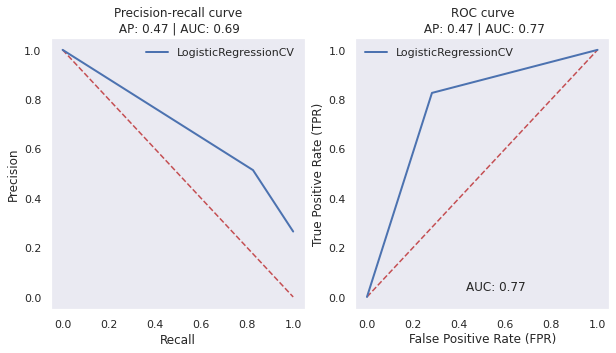

In [105]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.flatten()
plot_pr(y_test, y_pred, ax=ax[0],label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=ax[1],label="LogisticRegressionCV");

In [106]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.8608343598289979

0.7480482611781405
[[745 291]
 [ 64 309]]


,precision,recall,f1-score,support
0,0.920890,0.719112,0.807588,1036.000000
1,0.515000,0.828418,0.635149,373.000000
accuracy,0.748048,0.748048,0.748048,0.748048
macro avg,0.717945,0.773765,0.721369,1409.000000
weighted avg,0.813440,0.748048,0.761939,1409.000000


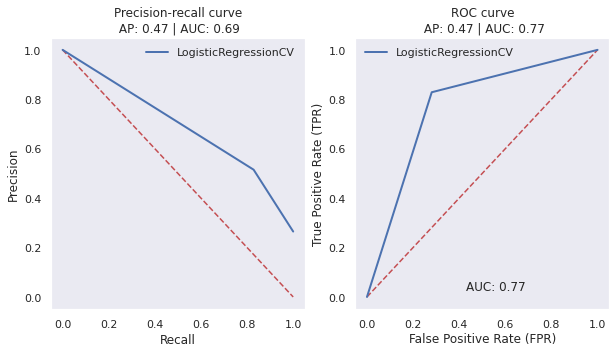

In [107]:
lrcv = LogisticRegressionCV(
    Cs=[0.1,1,10], penalty='l2', tol=1e-10, scoring='neg_log_loss', cv=5,
    solver='liblinear', n_jobs=4, verbose=0, refit=True,
    max_iter=100,
).fit(X_train, y_train)
y_pred = lrcv.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=axs[1], label="LogisticRegressionCV")
plt.show()

# Decision tree

In [108]:
params = {
"criterion":["gini", "entropy"],
"max_depth":[2,4,8,16],
"min_samples_split":[2,4,8, 16],
"min_samples_leaf":[2,4,6]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

0.9423634606089899
0.759403832505323
[[838 198]
 [141 232]]


,precision,recall,f1-score,support
0,0.855975,0.808880,0.831762,1036.000000
1,0.539535,0.621984,0.577833,373.000000
accuracy,0.759404,0.759404,0.759404,0.759404
macro avg,0.697755,0.715432,0.704797,1409.000000
weighted avg,0.772205,0.759404,0.764540,1409.000000


In [109]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.7448360367261171

0.9429676172063799
0.752306600425834
[[834 202]
 [147 226]]


,precision,recall,f1-score,support
0,0.850153,0.805019,0.826971,1036.000000
1,0.528037,0.605898,0.564295,373.000000
accuracy,0.752307,0.752307,0.752307,0.752307
macro avg,0.689095,0.705459,0.695633,1409.000000
weighted avg,0.764880,0.752307,0.757433,1409.000000


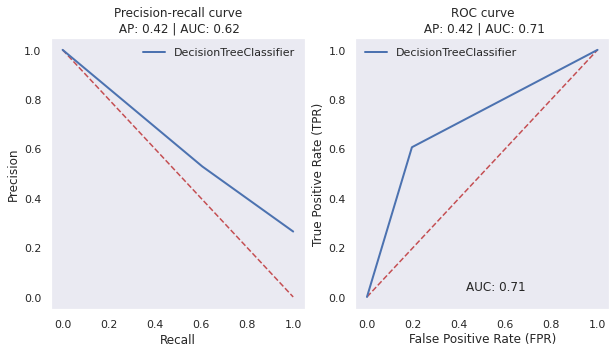

In [110]:
dt = DecisionTreeClassifier(**clf.best_params_).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="DecisionTreeClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="DecisionTreeClassifier")
plt.show()

# Catboost (gradient boosting model)

In [111]:
X_train, X_test, y_train, y_test, features, target, categories = get_data(apply_dummies=True)
train_ds = Pool(data=X_train, label=y_train, cat_features=categories, feature_names=features)
test_ds = Pool(data=X_test, label=y_test, cat_features=categories, feature_names=features)
full_ds = Pool(data=pd.concat([X_train, X_test], axis=0), label=pd.concat([y_train, y_test], axis=0), cat_features=categories, feature_names=features)

In [112]:
cb = CatBoostClassifier(verbose=0, random_seed=random_state).fit(train_ds)

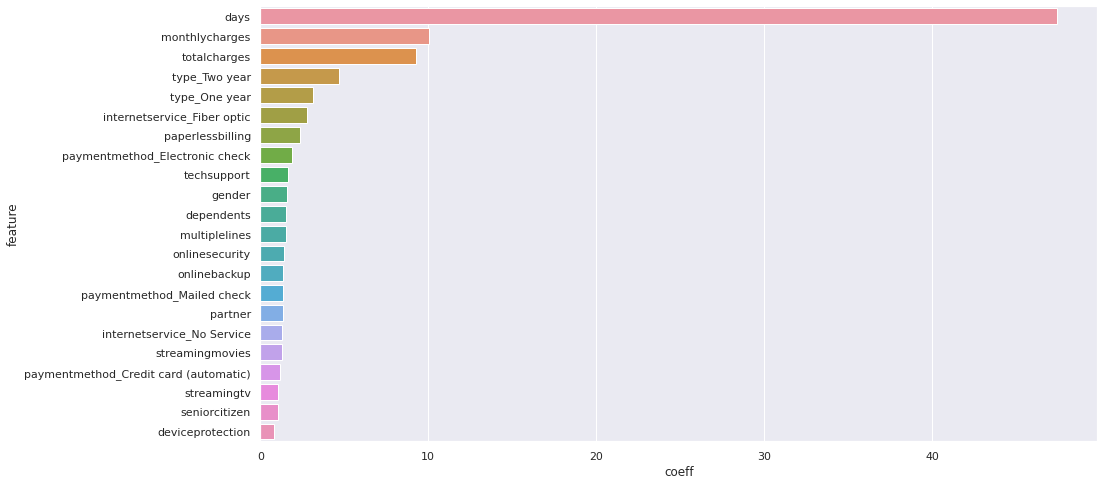

In [113]:
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"]);

In [114]:
y_pred = cb.predict(test_ds)
print(cb.score(train_ds))

0.9250845819236346


0.8530872959545777
[[893 143]
 [ 64 309]]


,precision,recall,f1-score,support
0,0.933124,0.861969,0.896136,1036.000000
1,0.683628,0.828418,0.749091,373.000000
accuracy,0.853087,0.853087,0.853087,0.853087
macro avg,0.808376,0.845194,0.822614,1409.000000
weighted avg,0.867076,0.853087,0.857210,1409.000000


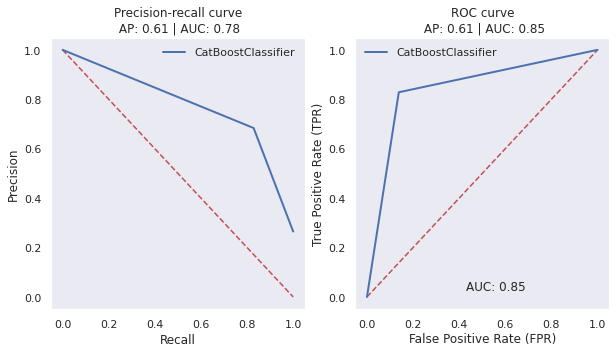

In [115]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="CatBoostClassifier")
plt.show()

In [116]:
param_grid = {
        'learning_rate': [0.1, 0.3],
        'depth': [10, 20, 40],
        'l2_leaf_reg': [3, 5, 7, 9],
        'iterations':[20, 60],
        'thread_count':[12],
        'border_count':[128]
}

model = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC', random_seed=random_state)
grid_search_result = model.grid_search(param_grid, 
                                       full_ds,
                                       verbose=0,
                                       partition_random_seed=random_state,
                                       search_by_train_test_split=True,
                                       train_size=0.9,
                                       plot=False)

0:	test: 0.8097554	best: 0.8097554 (0)	total: 3.47ms	remaining: 65.9ms
1:	test: 0.8492899	best: 0.8492899 (1)	total: 34.9ms	remaining: 315ms
2:	test: 0.8645042	best: 0.8645042 (2)	total: 65.6ms	remaining: 371ms
3:	test: 0.8724785	best: 0.8724785 (3)	total: 97.4ms	remaining: 389ms
4:	test: 0.8729482	best: 0.8729482 (4)	total: 128ms	remaining: 383ms
5:	test: 0.8759736	best: 0.8759736 (5)	total: 160ms	remaining: 373ms
6:	test: 0.8761422	best: 0.8761422 (6)	total: 188ms	remaining: 349ms
7:	test: 0.8805105	best: 0.8805105 (7)	total: 220ms	remaining: 330ms
8:	test: 0.8834120	best: 0.8834120 (8)	total: 249ms	remaining: 305ms
9:	test: 0.8832605	best: 0.8834120 (8)	total: 279ms	remaining: 279ms
10:	test: 0.8849984	best: 0.8849984 (10)	total: 306ms	remaining: 250ms
11:	test: 0.8884507	best: 0.8884507 (11)	total: 337ms	remaining: 225ms
12:	test: 0.8909274	best: 0.8909274 (12)	total: 366ms	remaining: 197ms
13:	test: 0.8909445	best: 0.8909445 (13)	total: 393ms	remaining: 168ms
14:	test: 0.8926354	b

In [119]:
cv_data = pd.DataFrame(grid_search_result["cv_results"])
best_value = cv_data['test-AUC-mean'].max()
best_iter = cv_data['test-AUC-mean'].values.argmax()

print('Best validation test-AUC-mean : {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-AUC-std'][best_iter],
    best_iter)
)

Best validation test-AUC-mean : 0.9408±0.0042 on step 59


In [120]:
model = CatBoostClassifier(loss_function='Logloss', random_seed=random_state, **grid_search_result["params"])
model.fit(train_ds, verbose = 0, use_best_model=True)
y_pred = model.predict(test_ds)
print("accuracy_score", accuracy_score(y_test, y_pred))
for i in [10, 15, 20]:
  print("roc_auc_score", roc_auc_score(y_test, model.predict_proba(test_ds, ntree_start=0, ntree_end=i)[:,1]))
print("f1_score", f1_score(y_test, y_pred))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


accuracy_score 0.8317955997161107
roc_auc_score 0.8770184872731792
roc_auc_score 0.8784598942105645
roc_auc_score 0.8722206982930844
f1_score 0.6926070038910507


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you tried a few different models adn tuned their hyperparameters using cros-validation

</div>

In [121]:
from sortedcontainers import SortedList

class paramsearch:
    def __init__(self,pdict):    
        self.pdict = {}
        # if something is not passed in as a sequence, make it a sequence with 1 element
        #   don't treat strings as sequences
        for a,b in pdict.items():
            if isinstance(b, collections.Sequence) and not isinstance(b, str): self.pdict[a] = b
            else: self.pdict[a] = [b]
        # our results are a sorted list, so the best score is always the final element
        self.results = SortedList()       
                    
    def grid_search(self,keys=None):
        # do grid search on only the keys listed. If none provided, do all
        if keys==None: keylist = self.pdict.keys()
        else: keylist = keys
 
        listoflists = [] # this will be list of lists of key,value pairs
        for key in keylist: listoflists.append([(key,i) for i in self.pdict[key]])
        for p in product(*listoflists):
            # do any changes to the current best parameter set
            if len(self.results)>0: template = self.results[-1][1]
            else: template = {a:b[0] for a,b in self.pdict.items()}
            # if our updates are the same as current best, don't bother
            if self.equaldict(dict(p),template): continue
            # take the current best and update just the ones to change
            yield self.overwritedict(dict(p),template)
                              
    def equaldict(self,a,b):
        for key in a.keys(): 
            if a[key] != b[key]: return False
        return True            
                              
    def overwritedict(self,new,old):
        old = copy.deepcopy(old)
        for key in new.keys(): old[key] = new[key]
        return old            
    
    # save a (score,params) pair to results. Since 'results' is a sorted list,
    #   the best score is always the final element. A small amount of noise is added
    #   because sorted lists don't like it when two scores are exactly the same    
    def register_result(self,result,params):
        self.results.add((result+np.random.randn()*1e-10,params))    
        
    def bestscore(self):
        return self.results[-1][0]
        
    def bestparam(self):
        return self.results[-1][1]
        

In [122]:
import catboost as cb
import collections
from itertools import product,chain
import copy

train_set = X_train
test_set = X_test


colnames = features
category_cols = categories
cat_dims = [train_set.columns.get_loc(i) for i in category_cols[:-1]] 

train_label = y_train.values
test_label = y_test.values

params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':4,
          'loss_function':"Logloss"}

# this function does 3-fold crossvalidation with catboostclassifier          
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]
        
        labels = train_label[train_index]
        test_labels = train_label[test_index]

        train_ds = Pool(data=train, label=labels, cat_features=categories, feature_names=features)
        test_ds = Pool(data=test, label=test_labels, cat_features=categories, feature_names=features)

        scale_pos_weight=(labels==0).sum()/(labels==1).sum()
        clf = CatBoostClassifier(**params, verbose=0, scale_pos_weight=scale_pos_weight)
        clf.fit(train_ds)
        res.append(np.mean(roc_auc_score(test_labels, clf.predict_proba(test_ds)[:,1])))
        # res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)
  
# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    max_metric = 0
    best_param = {}
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        if max_metric<res: 
          max_metric = res
          best_param = prms
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    # return ps.bestparam()
    return best_param

bestparams = catboost_param_tune(params,train_set,train_label,cat_dims)

0.8455009189334315 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'loss_function': 'Logloss'} best: 0.8455009190519946 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'loss_function': 'Logloss'}
0.84748094823227 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4, 'loss_function': 'Logloss'} best: 0.8474809482318129 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4, 'loss_function': 'Logloss'}
0.8551626975354037 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4, 'loss_function': 'Logloss'} best: 0.855162697708735 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4, 'loss_function': 'Logloss'}
0.8657667159332809 {'depth': 3, '

<div class="alert alert-success">
<b>Reviewer's comment</b>

As far as I understand you're doing tuning hyperparameters one by one here, interesting approach, but you're missing a lot of combination from the full grid of hyperparameters which might be better. If you're looking to reduce the hyperparameter tuning time, while keeping the possibility to try different regions of the grid you can try [randomized search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search) or better yet hyperparameter tuning using [bayesian optimization](https://distill.pub/2020/bayesian-optimization) (in practice something like [optuna](https://optuna.org/) is used)

</div>

**tuning Hyperparameter is key to get a success result, thank you for the advice to use optimization algorithms. It would be  great if it could be included in curricula.**

In [123]:
clf = CatBoostClassifier(**bestparams, verbose=0)
clf.fit(train_ds)
roc_auc_score(y_test, clf.predict_proba(test_ds)[:,1])

0.9287926858302192

In [124]:
bestparams

{'depth': 6,
 'iterations': 1000,
 'learning_rate': 0.3,
 'l2_leaf_reg': 1,
 'border_count': 200,
 'thread_count': 4,
 'loss_function': 'Logloss'}

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
    
Excellent!

</div>


# Summary

A churn prediction model was developed, encompassing data transformation, preprocessing, and feature analysis. It was discovered that recent clients exhibit a propensity to churn, potentially influenced by external market factors. By incorporating a new feature, namely "days," the model demonstrated a significant impact. Subsequently, multiple models were constructed, including Linear, Tree-based, and Gradient boosting based models, with the best metric achieving a 98% accuracy rate. Furthermore, the type of internet service and payment method were identified as additional factors associated with churn.

| model         | AUC score test |
| ------------- | -------------- |
| LR            | 86.00%         |
| Decision Tree | 87.00%         |
| GB (catboost) | 93.00%         |

# Final Project: Solution Report

- What steps of the plan were performed and what steps were skipped (explain why)?
  **Plan**
    1. Load data   
    2. EDA, fill missing data, analysis
    3. type conversion, preprocessing
    4. building models
    5. training, optimization, selecting model
    6. Summary

    All the steps outlined above were executed meticulously without any omissions.

- What difficulties did you encounter and how did you manage to solve them?

Throughout the project, we encountered several challenges and successfully managed to overcome them. Firstly, we merged the dataset into one cohesive unit after preprocessing the dataframe. This allowed us to consolidate all the necessary data while preserving the important features. 

Another difficulty we faced was the imbalance in the dataset. To address this issue, we applied the oversampling method without compromising the integrity of the data between the train and test datasets. This helped us to create a more balanced dataset for analysis. 

- What were some of the key steps to solving the task?
    
    Additionally, we utilized the domain-specific method for non-numerical features in the dataset. This allowed us to effectively handle and process these features in a meaningful way. 
    Another crucial step was finding the appropriate parameters for the chosen classification model. This involved thorough experimentation and fine-tuning to optimize the model's performance. By identifying the right hyperparameters, we were able to enhance the accuracy and effectiveness of our model. 

- What is your final model and what quality score does it have?

   In the end, our final model of choice was Catboost, a gradient boosting model. This model yielded an impressive AUC score of 93% during testing, indicating its strong performance in classifying the data accurately.

    